# Install Dependencies

In [1]:
!pip install torch==1.9.0 torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.14.1
    Uninstalling torchtext-0.14.1:
      Successfully uninstalled torchtext-0.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.14.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.13.1+cu116 requires torch==1.13.1, but you have torch 1.9.0 which is incompatible.


# Import Necessary Libraries

In [27]:
import torch
import torch.nn as nn

import random
import argparse

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from torchtext.legacy import data
from torchtext.legacy import datasets

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import time
from datetime import datetime

import spacy
nlp = spacy.load('en_core_web_sm')

# Use GPU
Set Device = CUDA if available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Hyper-Parameters

In [4]:
argument_parser = argparse.ArgumentParser()
argument_parser.add_argument("--epochs", dest = "EPOCHS", type = int, default = 5)
argument_parser.add_argument("--batch_size", dest = "BATCH_SIZE", type = int, default = 64)
argument_parser.add_argument("--embed_dim", dest = "EMBED_DIM", type = int, default = 100)
argument_parser.add_argument("--hidden_dim", dest = "HIDDEN_DIM", type = int, default = 256)
argument_parser.add_argument("--num_layers", dest = "NUM_LAYERS", type = int, default = 2)
argument_parser.add_argument("--bidirectional", dest = "BIDIRECTIONAL", type = bool, default = True)
argument_parser.add_argument("--optimizer", dest = "OPTIMIZER", type = str, default = 'Adam')
argument_parser.add_argument("--loss_fn", dest = "LOSS_FN", type = str, default = 'BCELoss')
argument_parser.add_argument("--learning_rate", dest = "LEARNING_RATE", type = float, default =  1e-2)
argument_parser.add_argument("--dropout", dest = "DROPOUT", type = float, default =  0.2)
arguments, unknown = argument_parser.parse_known_args()

# Set SEED value for reproducible results
# and
# Load Dataset

In [5]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

# Create Dataset Splits and Build Vocab

In [6]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 10.5MB/s]


Number of training examples: 25000
Number of testing examples: 25000


In [7]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [8]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")
print(f"Most common 20 tokens in TEXT vocabulary: {TEXT.vocab.freqs.most_common(20)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
Most common 20 tokens in TEXT vocabulary: [('the', 204529), (',', 194102), ('.', 166563), ('a', 110287), ('and', 110143), ('of', 101580), ('to', 94293), ('is', 76990), ('in', 61616), ('I', 54577), ('it', 53786), ('that', 49458), ('"', 44570), ("'s", 43600), ('this', 42568), ('-', 37811), ('/><br', 35793), ('was', 34872), ('as', 30541), ('with', 30138)]


# Dictionary for words (Vocabulary)


In [9]:
word2idx = TEXT.vocab.stoi

idx2word = { idx: word for word, idx in word2idx.items() }

unk_token = word2idx['<unk>']
padding_token = word2idx['<pad>']
print(f'UNK Token: {unk_token}')
print(f'PAD Token: {padding_token}')

UNK Token: 0
PAD Token: 1


# Add Input Dim and Output Dim to arguments

In [10]:
argument_parser.add_argument("--input_dim", dest = "INPUT_DIM", type = int, default = len(word2idx))
argument_parser.add_argument("--output_dim", dest = "OUTPUT_DIM", type = int, default = 1)
arguments, unknown = argument_parser.parse_known_args()
print(arguments)

Namespace(BATCH_SIZE=64, BIDIRECTIONAL=True, DROPOUT=0.2, EMBED_DIM=100, EPOCHS=5, HIDDEN_DIM=256, INPUT_DIM=25002, LEARNING_RATE=0.01, LOSS_FN='BCELoss', NUM_LAYERS=2, OPTIMIZER='Adam', OUTPUT_DIM=1)


# IMDB Dataset Class

In [11]:
class IMDBDataset(Dataset):

  def __init__(self, 
               data):
      self.data = data.examples

  def __len__(self):
      return len(self.data)

  def __getitem__(self, 
                  idx: int):
      """
      Returns
      -------
      tuple
            a tuple of encoded text and encoded label from the 
            dataset (an instance from a dataset given by idx)
      """
      # Encoding Text
      encoded_text = self.encode_text(self.data[idx].text)
      # Encoding Label
      encoded_label = self.encode_label(self.data[idx].label)
      return encoded_text, encoded_label

  def encode_text(self, 
                  text: list):
      text_vector = list()
      for word in text:
          if word in word2idx:
              text_vector.append(word2idx[word])
          else:
              text_vector.append(1)
      return text_vector

  def encode_label(self, 
                   label: int):
      label = 0 if label == 'pos' else 1
      return label

# Datset Object for DataLoader

In [12]:
train_ds = IMDBDataset(train_data)

val_ds = IMDBDataset(valid_data)

test_ds = IMDBDataset(test_data)

# Custom Collate function

In [13]:
def custom_collate_fn(batch):
    """
    Adds padding token '0' at the end of each text vector to make it
    of the same length as the maximum length input in the batch.

    Returns
    -------
    tuple
        a tuple of padded text tensors, label tensors and text lengths tensor in a batch
    """
    texts, labels = zip(*batch)
    
    texts_tensor = [torch.tensor(text, device = device) for text in texts]
    labels_tensor = torch.tensor(labels, device = device)

    lengths = [len(text) for text in texts]
    lengths = torch.tensor(lengths, device = 'cpu') # Lengths need to be on CPU
    
    texts_padded = pad_sequence(texts_tensor, batch_first = False, padding_value = padding_token)
    
    return texts_padded, labels_tensor, lengths

# PyTorch Data Loaders

In [14]:
train_loader = DataLoader(train_ds, 
                          batch_size = arguments.BATCH_SIZE, 
                          shuffle = True, 
                          collate_fn = custom_collate_fn)

val_loader = DataLoader(val_ds, 
                        batch_size = arguments.BATCH_SIZE, 
                        shuffle = True, 
                        collate_fn = custom_collate_fn)

test_loader = DataLoader(test_ds, 
                         batch_size = arguments.BATCH_SIZE, 
                         shuffle = False, 
                         collate_fn = custom_collate_fn)

# LSTM Model

In [15]:
class LSTM(nn.Module):

    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout):
        super(LSTM, self).__init__()
        # Initialize Embedding Layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # Initialzie LSTM layer to process the vector sequences 
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = False)
        num_directions = 2 if bidirectional else 1
        # Initialize Dense layer to predict
        self.fc = nn.Linear(hidden_dim * num_directions, output_dim)
        # Initialize dropout to improve with regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, 
                x, 
                x_lengths):
        # Embedding Layer
        embedded = self.embedding(x)
        # Dropout Layer before LSTM Layer
        embedded = self.dropout(embedded)
        # Packed Sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            x_lengths, 
                                                            batch_first = False, 
                                                            enforce_sorted = False)
        # LSTM Layer
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, 
                                                                  batch_first = False)
        # Concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers and Apply Dropout
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        # Fully Connected Layer
        output = self.fc(hidden)
        return output

In [16]:
model = LSTM(arguments.INPUT_DIM, 
             arguments.EMBED_DIM, 
             arguments.HIDDEN_DIM, 
             arguments.OUTPUT_DIM, 
             arguments.NUM_LAYERS, 
             arguments.BIDIRECTIONAL, 
             arguments.DROPOUT).to(device)

print('LSTM Model: ', model)

LSTM Model:  LSTM(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


# Total Trainable parameters for LSTM Model

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


# Train and Validation Functions for the Model

In [18]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

# Model Train Function
def train(loader, 
          model, 
          optimizer, 
          loss_fn):
    model.train()
    losses = []
    pbar = tqdm(loader, desc = 'Training...', colour = 'red')
    for x, y, x_lengths in pbar:
        optimizer.zero_grad()
        
        # Calculate y_pred
        y_pred = model(x, x_lengths).squeeze(1)
        
        loss = loss_fn(y_pred, y.float())
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())

        acc = binary_accuracy(y_pred, y)
        
        # Calculate gradients for w/b
        loss.backward()  
        # Update weights according to optimizer rules
        optimizer.step()          
    return sum(losses) / len(losses), acc

# Model Evaluate Function
def evaluate(loader, 
             model, 
             loss_fn):
    model.eval()
    losses = []
    pbar = tqdm(loader, desc = 'Evaluation...', colour = 'green')
    for x, y, x_lengths in pbar:

        # Calculate y_pred
        y_pred = model(x, x_lengths).squeeze(1)
        
        loss = loss_fn(y_pred, y.float())
        pbar.set_postfix({'Loss': loss.item()})
        losses.append(loss.item())

        acc = binary_accuracy(y_pred, y)
              
    return sum(losses) / len(losses), acc

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Model Training and Validation

In [20]:
# Optimizer
if arguments.OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = arguments.LEARNING_RATE)

# Loss Function
if arguments.LOSS_FN == 'BCELoss':
    loss_fn = nn.BCEWithLogitsLoss().to(device)

# Initialize Best Validation Loss
best_valid_loss = float('inf')
    
# Path to Save Best Model
PATH = f'lstm-best-model.pt'

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

batch_start_time = time.time()

for epoch in range(arguments.EPOCHS):

    start_time = time.time()
    
    # Avg Train Loss, Train Accuracy
    train_loss, train_acc = train(train_loader, 
                                  model, 
                                  optimizer, 
                                  loss_fn)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc.detach().cpu().numpy())

    # Avg Val Loss, Val Accuracy
    val_loss, val_acc = evaluate(val_loader, 
                                 model, 
                                 loss_fn)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc.detach().cpu().numpy())

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'\n\tEpoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%\n')

    if val_loss < best_valid_loss:
        best_valid_loss = val_loss
        torch.save(model.state_dict(), PATH)

batch_end_time = time.time()
batch_elapsed_time = batch_end_time - batch_start_time
print(f'Training Time for Batch Size: {arguments.BATCH_SIZE} -> {batch_elapsed_time:.2f}s')

Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 12.03it/s, Loss=0.674]



	Epoch: 01 | Epoch Time: 1m 15s
	Train Loss: 0.691 | Train Acc: 64.29%
	Validation Loss: 0.681 | Validation Acc: 58.33%



Evaluation...: 100%|██████████| 118/118 [00:10<00:00, 10.76it/s, Loss=0.653]



	Epoch: 02 | Epoch Time: 1m 16s
	Train Loss: 0.673 | Train Acc: 78.57%
	Validation Loss: 0.668 | Validation Acc: 66.67%



Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 12.07it/s, Loss=0.503]



	Epoch: 03 | Epoch Time: 1m 15s
	Train Loss: 0.598 | Train Acc: 89.29%
	Validation Loss: 0.528 | Validation Acc: 75.00%



Evaluation...: 100%|██████████| 118/118 [00:10<00:00, 10.92it/s, Loss=0.328]



	Epoch: 04 | Epoch Time: 1m 16s
	Train Loss: 0.495 | Train Acc: 78.57%
	Validation Loss: 0.497 | Validation Acc: 83.33%



Evaluation...: 100%|██████████| 118/118 [00:09<00:00, 11.98it/s, Loss=0.11]


	Epoch: 05 | Epoch Time: 1m 15s
	Train Loss: 0.421 | Train Acc: 96.43%
	Validation Loss: 0.472 | Validation Acc: 100.00%

Training Time for Batch Size: 64 -> 379.71s


# Line Plot Comparison: 
1. Training vs Val Loss
2. Training vs Val Accuracy



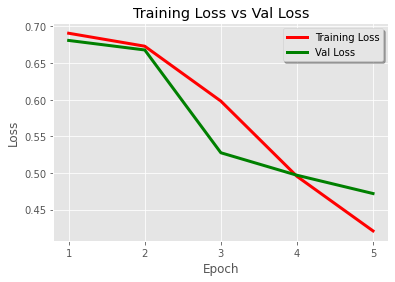

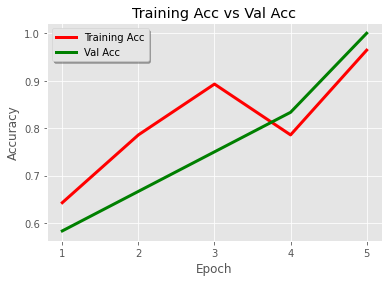

In [21]:
epochs = np.arange(arguments.EPOCHS) + 1

def plot_line(line_A_vals, 
              line_B_vals, 
              line_A_label, 
              line_B_label, 
              xlabel, 
              ylabel, 
              title):
    plt.style.use('ggplot')
    plt.plot(epochs, line_A_vals, label = line_A_label, color = "red", linewidth = '3')
    plt.plot(epochs, line_B_vals, label = line_B_label, color = "green", linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(epochs)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()
    
# Training vs Val Loss Plot
plot_line(train_loss_list, 
          val_loss_list, 
          'Training Loss', 
          'Val Loss', 
          'Epoch', 
          'Loss', 
          'Training Loss vs Val Loss')

# Training vs Val Acc Plot
plot_line(train_acc_list, 
          val_acc_list, 
          'Training Acc', 
          'Val Acc', 
          'Epoch', 
          'Accuracy', 
          'Training Acc vs Val Acc')

## Load the saved model

In [22]:
saved_model = LSTM(arguments.INPUT_DIM, 
                   arguments.EMBED_DIM, 
                   arguments.HIDDEN_DIM, 
                   arguments.OUTPUT_DIM, 
                   arguments.NUM_LAYERS, 
                   arguments.BIDIRECTIONAL, 
                   arguments.DROPOUT).to(device)

saved_model.load_state_dict(torch.load(PATH))
saved_model.eval()

LSTM(
  (embedding): Embedding(25002, 100)
  (lstm): LSTM(100, 256, num_layers=2, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Test Loss and Accuracy

In [23]:
# Avg Test Loss, Test Accuracy
test_loss, test_acc = evaluate(test_loader, 
                               saved_model, 
                               loss_fn)
print(f'\n\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluation...: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s, Loss=0.491]


	Test Loss: 0.495 | Test Acc: 80.00%


# Deliverable Plots

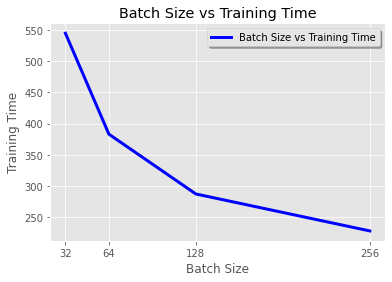

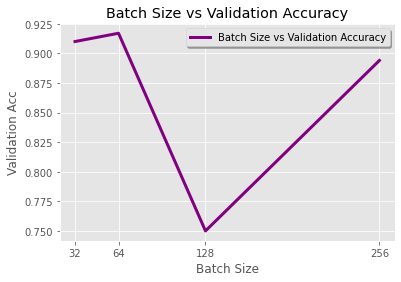

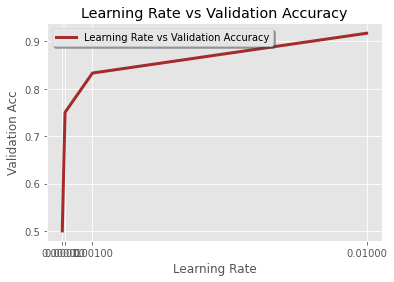

In [24]:
batch_size = [32, 64, 128, 256]
training_time = [545.12, 382.94, 286.81, 227.46]
val_set_acc = [0.91, 0.917, 0.75, 0.894]
learning_rate_vals = [0.01, 0.001, 0.0001, 0.00001]
val_set_acc_lr = [0.917, 0.833, 0.75, 0.50]

def plot_comp_line(x_vals, 
              y_vals,
              line_label,
              xlabel, 
              ylabel, 
              title, 
              line_color):
    plt.style.use('ggplot')
    plt.plot(x_vals, y_vals, label = line_label, color = line_color, linewidth = '3')
    plt.xlabel(xlabel)
    plt.xticks(x_vals)
    plt.ylabel(ylabel)
    plt.title(title, color = 'black')
    plt.legend(shadow = True)
    plt.show()

# Batch Size vs Training Time Plot
plot_comp_line(batch_size, 
               training_time, 
               'Batch Size vs Training Time',  
               'Batch Size', 
               'Training Time',
               'Batch Size vs Training Time', 
               'blue')

# Batch Size vs Val Acc Plot
plot_comp_line(batch_size, val_set_acc, 
               'Batch Size vs Validation Accuracy', 
               'Batch Size', 
               'Validation Acc',
               'Batch Size vs Validation Accuracy', 
               'purple')

# Learning Rate vs Val Acc Plot
plot_comp_line(learning_rate_vals, val_set_acc_lr, 
               'Learning Rate vs Validation Accuracy', 
               'Learning Rate', 
               'Validation Acc',
               'Learning Rate vs Validation Accuracy', 
               'brown')

# Test for Model Correctness

In [25]:
max_n_test_instances = 5
i = 1
for x, _, x_lengths in val_loader:
  score = saved_model(x, x_lengths).squeeze(1)
  print(score)
  if i >= max_n_test_instances:
    break
  else:
    i += 1

tensor([ 3.0870,  0.9603, -1.3595, -2.1795,  1.4163,  1.9596,  1.1898,  3.0208,
         2.7511,  3.3190, -3.1601, -4.1265, -1.8978,  1.1842,  2.7568, -0.7485,
         0.5536, -3.2794,  0.6370,  2.2355, -2.7464, -1.3944, -1.4907, -1.5337,
         5.1682, -2.8805, -1.5846,  3.9179,  2.0945, -1.1521,  4.1228, -1.3395,
        -2.2316, -1.6095, -2.9479,  0.5423, -1.6015,  1.7884, -0.5046, -1.6289,
         0.1246, -1.2271, -3.0610, -0.2646, -2.0419, -2.3358,  1.7000,  2.8786,
        -3.7736, -0.6439, -2.0342, -1.8706,  2.0506, -2.1195,  1.8233, -2.4538,
         5.8686,  3.0798, -0.2680, -1.2010, -2.2113, -1.7547,  2.8502, -2.9275],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor([ 0.0201,  4.6470,  1.0993,  3.5044, -1.9578, -1.6108,  0.4699,  4.2364,
         1.0928, -0.9416,  2.1714,  3.6820,  4.2633,  0.8771, -1.6315,  5.6076,
         3.2560,  2.4721,  4.0353, -2.6405,  2.8408,  2.2235, -2.5343, -1.0575,
         0.7230,  1.3994,  4.3804, -2.4219, -3.3372,  0.8787,  5.28

# Observation for the errors that LSTM makes
For first 50 sentences in the Dev(validation) set

In [38]:
def predict_sentiment(model, 
                      sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()


num_sent = 50
val_examples = valid_data.examples
j = 0
for i in range(len(val_examples)):
  input_seq = ' '.join(val_examples[i].text)
  gold_label = val_examples[i].label
  gold_label = val_ds.encode_label(gold_label)
  pred_label = round(predict_sentiment(saved_model, input_seq))
  if gold_label != pred_label:
    print(f'Input Sentence: {input_seq}')
    print(f'Gold Label: {gold_label}')
    print(f'Pred Label: {pred_label}')
  j += 1
  if j == num_sent:
    break

Input Sentence: I 'm a pretty old dude , old enough to remember the taste of Oreos and Coke as they were 50 - 55 years ago , when every taste for a kid was fresh . I wish I have somehow set some aside then is some magical suspended locker , so that I could taste those things today . This magical locker might even have adjusted the fabric of the food to account for how I 've drifted , physically and otherwise , a sort of dynamic chemistry of expectations . Over the half century , they would have had to adjust quite a bit , because you see I would have known that I set them aside . Eating one now would be a celebration of self and past , and story , and sense that would almost make the intervening years an anticipated reward.<br /><br />I did n't have enough sense to do that with original Coke . And I could n't have invented one of those magical psychic lockers  not then . But I did something almost as good . In the seventies , I really tuned into Roman Polanski . He was a strange and e